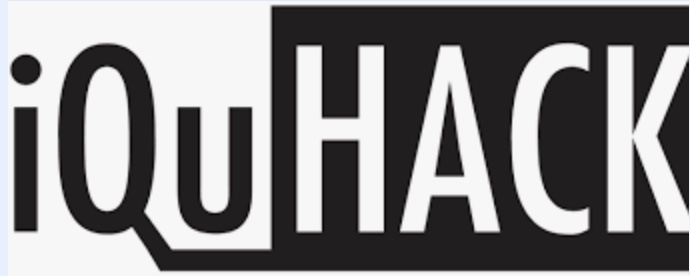

# Qunonians - IQuHack 2025
## D-Wave Challenge


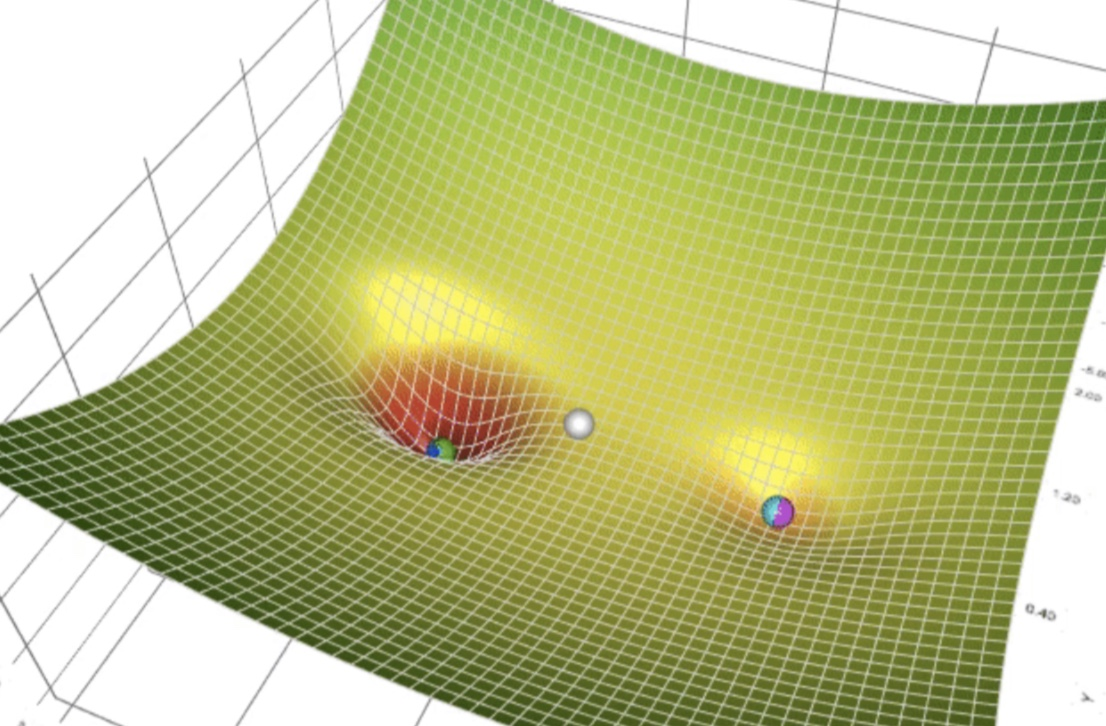

In [ ]:
#Install DWave SDK
!pip install dwave-ocean-sdk

#Import Packages
import numpy as np
from dwave.samplers import SimulatedAnnealingSampler
from dwave.system import DWaveSampler, EmbeddingComposite
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.6/158.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.7/103.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.6/225.6 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.4 MB/s eta 0:00:00


## Overview

Our challenge is a variation on the **quadratic assignment problem**, which, given $n$ facilities that can potentially be placed in $n$ different locations, finds the optimal possible arrangement for placing each facility in one of the locations given details about how important it is for any two distinct facilities to be near each other, and the distances between any two locations.

To shed some light on this problem, consider a somewhat practical application of it: a company is planning to build n planned storage warehouses and owns n possible locations for the warehouses. Only a single warehouse can be built per location. Every warehouse specializes in holding different kinds of goods, resulting in each warehouse requiring varying amounts of shipment to and from each other warehouse. In addition, every possible location has a different distance from every other possible location. The company wants to know which location each of their warehouses should be placed in such that the cost incurred by the company is minimized.

The optimal solution would put warehouses that exchange a high volume of goods at locations as close as possible to reduce cost, while allowing warehouses that don't need to interact as much to be further apart. Rewriting that in mathematical terms, the optimal solution would minimize

$$
\sum_{i=1}^{n} \sum_{j=1}^{n} f_{ij} \cdot d_{ij}
$$

where $d$ is the distance between two warehouses $i$ and $j$ and $f$ is some term representing the amount of "flow" of material between warehouses $i$ and $j$. More specifically, this problem should aim to minimize

$$
\sum_{i=1}^{n} \sum_{j=1}^{n} \sum_{k=1}^{n}  \sum_{l=1}^{n}f_{ij}
\cdot d_{kl} \cdot x_{ik} \cdot x_{jl}
$$

To make sense of this formula a bit, consider that the $i$ and $j$ indices represent warehouses $i$ and $j$, while the $k$ and $l$ indices represent possible locations $k$ and $l$. Then the $f_{ij}$ term describes the amount of "flow" of shipping between warehouses $i$ and $j$, and the $d_{kl}$ term describes the distance between possible locations $k$ and $l$. The $x_{ik}$ term is a binary term that can only take on the values of one (if warehouse $i$ is located at location $k$) or zero (if warehouse $i$ is NOT located at location $k$); the same logic goes for the $x_{jl}$ term. These binary terms ensure that, when summing over all possible $i,j,k$, and $l$, the product of flow between $i$ and $j$ with distance between $k$ and $l$ is only considered if warehouse $i$ is at location $k$ and warehouse $j$ is at location $l$.

We must minimize this sum while considering the additional constraints that a warehouse can only be placed at a single location, and a single location always holds one warehouse. In other words,

- $x_{ij}$ and $x_{kl}$ only have allowed values of $0$ or $1$
- if $j, l$ stay constant, the sum, looping through $0 < i < n$, of all $x_{ij}$ values should equal $1$, and the sum, looping through $0 < k < n$, of all $x_{kl}$ values should equal $1$.
- if $i, k$ stay constant, the sum, looping through $0 < j < n$, of all $x_{ij}$ values should equal $1$, and the sum, looping through $0 < l < n$, of all $x_{kl}$ values should equal $1$.

These constraints may be mathematically represented as $$\displaystyle\sum_{i = 0}^{n-1} x_{ij} = 1$$ for all $j$ as well as $$\displaystyle\sum_{j = 0}^{n-1} x_{ij} = 1$$ for all $i$.

Essentially these are mathematical representations of the statements "a warehouse must occupy exactly one location" and "a location must host exactly one warehouse."

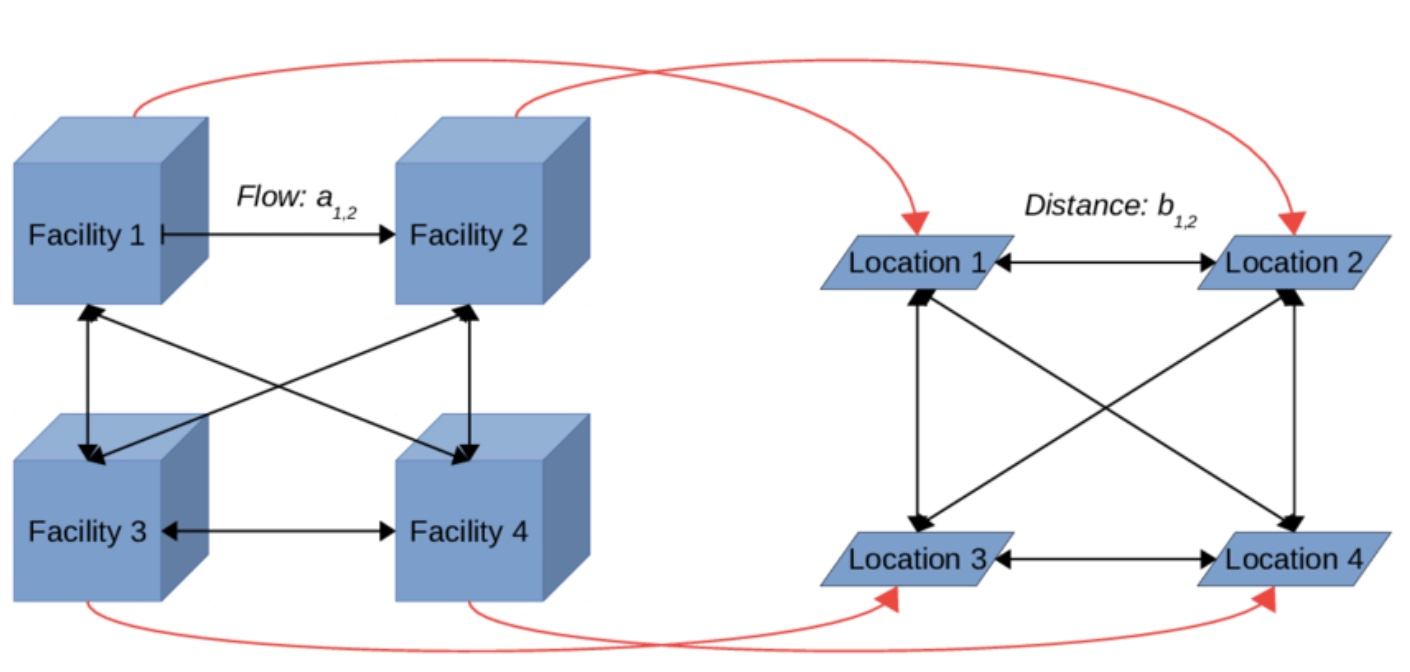


Let's consider a simple example: given four different warehouses, and four possible locations, find the optimal arrangement of warehouses. Every pair of warehouses has an "amount of flow" value associated with transport between them. An ideal way to mathematically represent the amount of flow between each pair of warehouses is with an $n \times n$ "flow matrix" ($4 \times 4$ in this case) such that index $ij$ is the amount of flow between warehouse $i$ and warehouse $j$:

$$F = \begin{bmatrix}f_{11} & \cdots & f_{1n} \\ f_{21} & \cdots & f_{2n} \\ \vdots & \ddots & \vdots \\ f_{n1} & \cdots & f_{nn}\end{bmatrix}$$

Note that the flow matrix is always symmetric i.e. index $ij$ is always equal to index $ji$ since the flow between warehouse $i$ and warehouse $j$ is equivalent to the flow between warehouse $j$ and warehouse $i$. Furthermore, the flow from warehouse $i$ to warehouse $i$ (to itself) is zero. In general, all the diagonal terms of the flow matrix equal zero.

We can also encode the distance between potential location $k$ and potential location $l$ in the same way, with an $n \times n$ "distance matrix" (with the same properties of symmetry and the diagonal terms being zero that the flow matrix displays).

$$D =  \begin{bmatrix}d_{11} & \cdots & d_{1n} \\ d_{21} & \cdots & d_{2n} \\ \vdots & \ddots & \vdots \\ d_{n1} & \cdots & d_{nn}\end{bmatrix}$$

Recall that the original summation function we aim to minimize has a term equal to $f_{ij} \cdot d_{kl}$, which is the flow between warehouses $i$ and $j$ multiplied by the distance between locations $k$ and $l$. There are $n^2$ values in the flow and distance matrices, representing $16$ (in this case) different ordered pairs of two warehouses or two potential locations. Combining the two conditions, to represent ordered sets of two warehouses IN two potential locations ($x_{ijkl}$), results in $n^2 \times n^2$ possibilities and an $n^2 \times n^2$ matrix called the **$Q$ matrix** (in this case, a $16\times16$ matrix). Specifically, the $Q$ matrix is formulated through the tensor product of $F$ and $D$. Each entry in this $16\times 16$ matrix of arrangements of two warehouses in two locations should be the product of the flow between the two warehouses $i,j$ and the distance between the two locations $k,l$, from the $f \cdot d$ term we aim to minimize. Due to its multiplicative properties, the tensor product is a natural way to obtain a $16 \times 16$ matrix of products of flow and distance.

Recall that the formula we aim to minimize is
$$
\sum_{i=1}^{n} \sum_{j=1}^{n} \sum_{k=1}^{n}  \sum_{l=1}^{n}f_{ij}
\cdot d_{kl} \cdot x_{ik} \cdot x_{jl}
$$

We've accounted for the $f_{ij} \cdot d_{kl}$ term with our $16 \times 16$ matrix of all possible $f \cdot d$ values, but now we must account for the binary (either $0$ or $1$) $x$-values, as their orientation determines the state that minimizes the sum. We consider the position matrix $$x =  \begin{bmatrix}x_{11} & \cdots & x_{1n} \\ x_{21} & \cdots & x_{2n} \\ \vdots & \ddots & \vdots \\ x_{n1} & \cdots & x_{nn}\end{bmatrix},$$ where we have $x_{ij} = 1$ if facility $i$ is at location $j$ and $x_{ij} = 0$ if not. A property of this matrix is that, if it satisfies the constraints, there should be exactly one $1$ per row and exactly one $1$ per column.

This matrix's $n \times n$ entries can be rewritten as $x_1, x_2, x_3, \dots, x_{n^2}$. Thus we can rewrite $x$ as a column vector, with elements $x_1, x_2, x_3, \dots, x_{n^2}$. This column vector is subject to the constraints, left over from the constraints in the matrix, that $x_1, x_2, \dots, x_n$ has one $1$ and otherwise is full of zeros, $x_{n+1}, x_{n+2}, \dots, x_{2n}$ has one $1$ and otherwise is full of zeros, and so on. These are the row constraints. The column constraints are that the set $x_1, x_{1+n}, x_{1+2n}, \dots, x_{1+(n-1)n}$ has one $1$ and otherwise is full of zeros, the set $x_2, x_{2+n}, x_{2+2n}, \dots, x_{2 + (n-1)n}$ has one $1$ and otherwise is full of zeros, and so on. All in all, this $n^2$-element column vector will be filled with $n$ $1$'s and the rest zeros. For example, in our $4 \times 4$ case, our $16$ element column vector has four $1$'s and twelve $0$'s. Those four $1$'s correspond to the four of the sixteen outcomes for $x_{ik} \cdot x_{jl}$ that return one instead of zero in the summation; multiplying the $Q$ matrix by this column vector returns a vector that is always zero except when we have $x_{ik} \cdot x_{jl} = 1$, in which case it returns the product $f_{ij} \cdot d_{kl}$ encoded in the tensor product of the flow and distance matrices. As a result, if we call this column vector $v$, minimizing the value encoded in the $1 \times 1$ matrix returned by $v^TQv$ is equivalent to minimizing the sum

$$
\sum_{i=1}^{n} \sum_{j=1}^{n} \sum_{k=1}^{n}  \sum_{l=1}^{n}f_{ij}
\cdot d_{kl} \cdot x_{ik} \cdot x_{jl}
$$

The last thing we need to do is get rid of the constraints, and to turn the problem from a constrained optimization problem into a standard QUBO (Quantum Unconstrained Binary Optimization) problem. To do so, we incur **penalties** on solutions that do not fit our constraints, by manipulating the Q-matrix and adding large numbers at certain indices such that solutions that do not fit our constraints gain such large values that they will never be the correct minimum value.








In [ ]:
# Example size
N = 3 # 3 facilities, 3 locations

#Flow matrix (f)
f = np.array([[0, 5, 2],
              [5, 0, 3],
              [2, 3, 0]])


#Distance matrix (d)
d = np.array([[0, 8, 15],
              [8, 0, 13],
              [15,13, 0]])

In [ ]:
# Initialize a zero QUBO matrix (upper triangular)
Q = np.zeros((N*N, N*N))

# Perform tensor product of f and d
for j in range(N):

    for k in range(N):
        for m in range(N):
            for n in range(m, N):
                # Cost of assigning facility j to location m and facility k to location n
                cost = f[j, k] * d[m, n]

                # Add the cost to the symmetric pair in the matrix
                Q[j * N + m, k * N + n] += cost
                if j != k or m != n:  # Avoid double-counting the diagonal
                    Q[k * N + n, j * N + m] += cost  # Ensure symmetry

## Formulating Movement Penalties

Though we thoroughly considered attempting to set constraints using DWave's built-in constraint methods, as hinted at in the problem statement, we chose to solve this problem with soft constraints in order to give the end user the highest amount of flexibility as possible. For example, when considering the motivating hospital example, we demonstrate that our library allows the user to decide to what degree they wish to constrain a department's motion - specifically, departments can be forbidden from any movement, or can be allowed to move with a reasonable penalty compared to closets. Furthermore, by directly interacting with the $Q$ matrix and binary variables, we can optimally tweak the system to maximize performance in a manner we simply would not have been able to if we worked with a more complex, abstracted method.

To implement our constraints, we take inspiration from the elegant classical formulation of a small QAP in [*Quantum Bridge Analytics I* by Glover, Kochenberger, and Du](https://arxiv.org/pdf/1811.11538).
Specifically, we first observe what conditions in our output we wish to constrain, then work backward to determine where to apply which penalties to Q.

The Quantum Annealing SDK, when input with an $N^2 \times N^2$ Q matrix, produces an output of form:
$[x_0, x_1, ...., x_{N^2}-1]$ where $x_i \in \{0,1\}$ for all $i$.

To intuitively explain this output, we reshape it to an $N \times N$ elementary matrix which is essentially a record of the position of each Facility at each time. Specifically, each location is encoded along the columns, while each facility is encoded along the rows:
$[[1,0,0],
  [0,1,0],
  [0,0,1]]$

Such a matrix is read as follows:
This matrix means Facility 0 (F0) is at Location 0 (L0), F1L1, and F2L2.
We can now work backwards from such a matrix to determine weighting for the constraints. Notably, no physical result can have more than 1 F at any given L, and no F can be at more than 1 L. This corresponds to the constraints that $(x_0 + x_1 + x_2 -1)$, $(x_0 + x_3 + x_6 -1)$, and all such row and column sums (minus 1) must be $0$ in any physical output. To make this problem simply implementable in our quadratic $Q$ formulation, we square each of these terms to ensure positive (undesirable) energy contributions and multiply them by our penalty factor (set very large for this constraint):

$Q_0x_0 + Q_{01}x_0x_1+ ... + P(x_0 + x_1 + x_2 -1)^2 + ... + P(x_0 + x_3 + x_6 -1)^2$

These $P$ terms can be shown to simplify (noting that $x_i^2$=$x_i$ for binary $x_i$) to form matching
$1-x_0-x_1-x_2+2x_0x_1+2x_0x_2+2x_1x_2$.

Ignoring the constant $-1$ present regardless of $x_i$, this clearly motivates out added constraint weighting of penalty $-P$ applied to the $Q_{ii}$ terms and penalty $2P$ applied to $Q_{ij}$ terms of $Q$. We separate this application out to specific 'constraint groups' in order to further improve user flexibility (to apply any desired 'boolean' constraints in the same form as the above).

We will revisit this formalism when encoding motion penalties and constraints later.

In [ ]:
# Define penalty weight
P = 2000  # Adjust as needed

# Define row and column constraints
constraint_groups = []

# Row constraints: each facility assigned exactly once
for i in range(N):
    constraint_groups.append([i * N + m for m in range(N)])

# Column constraints: each location receives exactly one facility
for m in range(N):
    constraint_groups.append([m + N * i for i in range(N)])  # Fixed index calculation

#Apply row and column constraints
for group in constraint_groups:
    for i in range(len(group)):
        for j in range(i, len(group)):  # Upper triangular terms
            var_i, var_j = group[i], group[j]
            if i == j:
                Q[var_i, var_j] += -P  # Linear penalty term
            else:
                Q[var_i, var_j] += 2 * P  # Stronger quadratic penalty
                Q[var_j, var_i] += 2 * P  # Ensure symmetry

Q matrix:
 [[-4000.  4000.  4000.  4000.    40.    75.  4000.    16.    30.]
 [ 4000. -4000.  4000.    40.  4000.    65.    16.  4000.    26.]
 [ 4000.  4000. -4000.    75.    65.  4000.    30.    26.  4000.]
 [ 4000.    40.    75. -4000.  4000.  4000.  4000.    24.    45.]
 [   40.  4000.    65.  4000. -4000.  4000.    24.  4000.    39.]
 [   75.    65.  4000.  4000.  4000. -4000.    45.    39.  4000.]
 [ 4000.    16.    30.  4000.    24.    45. -4000.  4000.  4000.]
 [   16.  4000.    26.    24.  4000.    39.  4000. -4000.  4000.]
 [   30.    26.  4000.    45.    39.  4000.  4000.  4000. -4000.]]


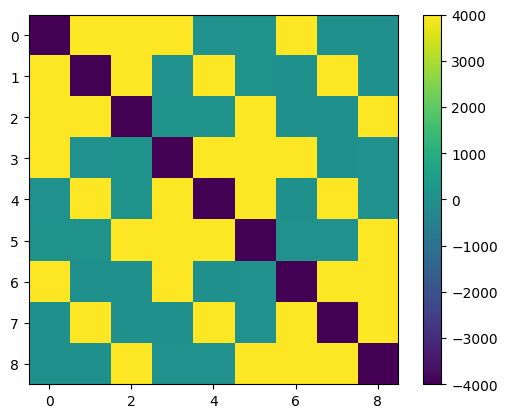

In [ ]:
# Now let's visualize our resultant Q matrix:
print("Q matrix:\n", Q)

#It is also convenient to use color-coding for better understanding:
plt.imshow(Q, cmap='viridis')
plt.colorbar()

In [ ]:
# Now, we run the sampler, imagining we are running it for real (like we did at the hackathon!)
sampler = SimulatedAnnealingSampler()

# Solve the problem using simulated annealing
response = sampler.sample_qubo(Q, num_reads=1000)

# Print the best solution
print(response.first.sample, "Energy:", response.first.energy)

# But this alone is not so useful --> reshape!
locs = np.array(list(response.first.sample.values())).reshape(N,N)
print(locs)

# This is THE solution under these constraints!

{0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1} Energy: -11782.0
[[1 0 0]
 [0 1 0]
 [0 0 1]]


## Time Evolution
Now that we have our system for a particular starting time, we would like to evolve it in time, responding to changes in the flow as they occur. A straightforward method of implementing this is in evaluating the Q matrix for the Flow at the new time and then adding a new Penalty term representing the cost of any movements.

We employ a simple formula to calculate the value of this penalty, following the advice of the challenge prompt to make it a function of the distance moved (though determining this value is more complex).

$ \text{Penalty}= P_{move} \times d_{moved} $

$P_{move}$ is a simple weighting factor that the user can specify.

It is in our application and determination of movement distances and effects that our prior formalism of the 'Location Matrix'.

To get the appropriate new Penalty matrix in the same shape as Q to add to Q (we describe this as matrix addition, but it is implemented element-wise for efficiency), we considered many approaches, including the tensor product of $1-\text{Loc}_{\text{prior state}}$ and the Distance matrix, along with other complex implementations involving the Hadamard product. However, we recognize that often the simplest solution is best, and in this spirit, came to a clever realization that, as in the initial constraint, we can simply reverse-engineer which terms are relevant by looking at the output:

Consider the old location matrix discussed above:
$\begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix}$

From this matrix, we want to apply our movement penalty to any outcomes in which F0 moves to L1 or L2, F1 moves to L0 or L2, and/or F3 moves to L2 or L1. We now focus on the F0 case to streamline our explanation. Movement away from L0 correspond to variables $x_1$ and $x_2$ in our new Location matrix, $\text{Loc}_{\text{current state}}$. So we simply determine the distance between L0, where F0 was in the prior state, and L1 and assign that penalty to $x_1$, and we conduct the same process for $x_2$. Applied over the whole matrix, this results in a diagonal penalty matrix weighted with appropriate distances, easily evolvable to future time states.

This provides an excellent approximate 'minimum-energy pathway' for the system as we evolve it in time, and is the **optimal solution** for the case where we do not know how the flow will change in the future ahead of time. However, what if we do? Though beyond the scope of the 24-hour timeframe, we have several ideas for such a problem. Most significantly, we can construct a new, larger Q matrix to optimize all $N^2 \times T$ binary variables corresponding to the system at all time steps. Due to the various movement cost interactions and penalties, this matrix is likely to be much larger than $N^2 T$ x $N^2 T$.

In [ ]:
#Now we consider a new flow rate

f_1 = np.array([[0, 1, 21],
                [1, 0, 13],
                [21, 13, 0]])

P_move = 10 # penalize movement by a factor of 10

previous_locations = locs # for now, we encode like this

# Initialize a zero QUBO matrix (upper triangular)
Q_1 = np.zeros((N*N, N*N))

# Perform tensor product of f and d
for j in range(N):
    for k in range(N):
        for m in range(N):
            for n in range(m, N):
                # Cost of assigning facility j to location m and facility k to location n
                cost = f_1[j, k] * d[m, n]

                # Add the cost to the symmetric pair in the matrix
                Q_1[j * N + m, k * N + n] += cost
                if j != k or m != n:  # Avoid double-counting the diagonal
                    Q_1[k * N + n, j * N + m] += cost  # Ensure symmetry

# Define row and column constraints
constraint_groups = []

# Row constraints: each facility assigned exactly once
for i in range(N):
    constraint_groups.append([i * N + m for m in range(N)])

# Column constraints: each location receives exactly one facility
for m in range(N):
    constraint_groups.append([m + N * i for i in range(N)])  # Fixed index calculation

#Apply row and column constraints
for group in constraint_groups:
    for i in range(len(group)):
        for j in range(i, len(group)):  # Upper triangular terms
            var_i, var_j = group[i], group[j]
            if i == j:
                Q[var_i, var_j] += -P  # Linear penalty term
            else:
                Q[var_i, var_j] += 2 * P  # Stronger quadratic penalty
                Q[var_j, var_i] += 2 * P  # Ensure symmetry

print(Q_1)

[[  0.   0.   0.   0.   8.  15.   0. 168. 315.]
 [  0.   0.   0.   8.   0.  13. 168.   0. 273.]
 [  0.   0.   0.  15.  13.   0. 315. 273.   0.]
 [  0.   8.  15.   0.   0.   0.   0. 104. 195.]
 [  8.   0.  13.   0.   0.   0. 104.   0. 169.]
 [ 15.  13.   0.   0.   0.   0. 195. 169.   0.]
 [  0. 168. 315.   0. 104. 195.   0.   0.   0.]
 [168.   0. 273. 104.   0. 169.   0.   0.   0.]
 [315. 273.   0. 195. 169.   0.   0.   0.   0.]]


In [ ]:
# But we must consider the effect of movement!
t=1
movement_penalty = np.zeros(N**4).reshape(N**2,N**2) # construct penalty matrix (implemented more efficiently in library)
if t > 0:
    for i in range(N):
        prev_loc = previous_locations[i]  # Previous location of facility i
        for m in range(N):
            move_penalty = P_move * d[prev_loc, m]
            movement_penalty[i * N + m][i * N + m] += move_penalty
print(f'Penalties: {movement_penalty}')

plt.imshow(movement_penalty, cmap='viridis')
plt.colorbar()

print(Q_1+movement_penalty)


ValueError: setting an array element with a sequence.

In [ ]:
# Now we optimize, in context!
sampler = SimulatedAnnealingSampler()

# Solve the problem using simulated annealing
response = sampler.sample_qubo(Q_1+movement_penalty, num_reads=1000)

# Print the best solution
locs_1 = np.array(list(response.first.sample.values())).reshape(N,N)
#print(response.first.sample, "Energy:", response.first.energy)
print(locs_1)

# Now we can go on forever! :)

## Facility Categories

Following again from the example above (though **easily and broadly applied elsewhere**, as we discuss below), imagine we now would like to distinguish our facilities into multiple groups, such as hospital departments vs supply closets. In this case, we store a new 1D array with length equal to the number of facilities and include a boolean or binary bit (or other distinguishing value, for the 3-category case) in each entry, corresponding to the $i$th facility by indexing in the location matrix and/or flow matrix. When assigning movement penalties, we include an additional multiplier if the facility moving is a department, given that departments are far harder to move in real life than closets. This looks like:
$ \text{Penalty}= P_{\text{department}}^{1-\text{is_closet[i]}} \times P_{move} \times d_{moved} $

Where is_closet[i] is the entry of the array specifying whether a facility is a closet (1) or a department (0).
We implement this below using booleans but the same inherent logic.

In [ ]:
num_closets = 1 # must be between 0 and N inclusive
is_closet = [True] * num_closets + [False] * (N - num_closets)

In [ ]:
# Now let's see how this affects Q1 from earlier:

t=1
movement_penalty_new = np.zeros(N**4).reshape(N**2,N**2) # construct penalty matrix (implemented more efficiently in library)
if t > 0:
    for i in range(N):
        prev_loc = previous_locations[i]  # Previous location of facility i
        for m in range(N):
            move_penalty = P_move * d[prev_loc, m]

            # Check if the location m corresponds to a closet
            if not is_closet[m]:  # If it's not a closet, increase the penalty
                move_penalty *= department_movement_penalty_factor  # Increase penalty for non-closet locations

            movement_penalty_new[i * N + m, i * N + m] += move_penalty
print(f'New Penalties: {movement_penalty_new}')
plt.imshow(movement_penalty_new, cmap='viridis')
plt.colorbar()

print(Q_1+movement_penalty_new)

In [ ]:
# We again optimize:
sampler = SimulatedAnnealingSampler()

# Solve the problem using simulated annealing
response = sampler.sample_qubo(Q_1+movement_penalty_new, num_reads=1000)

# Print the best solution
locs_1_new = np.array(list(response.first.sample.values())).reshape(N,N)
#print(response.first.sample, "Energy:", response.first.energy)
print(locs_1_new)

## Formulating Compatability Penalties

A crucial component of the problem is constraining the movement of facilities (i.e. hospital wards and supply closets), such that facilities of a certain class may only exchange locations within that class. For example, the locations of a series of hospital storage closets must be permitted to evolve as supply and demand fluctuate in time, but storage closets cannot be moved into wards, and vice versa. Hence, we apply an additional penalty, appended to the preceding movement penalty to discourage these exchanges.

Consider the hospital example. Suppose there are $m$ facilities, $n$ of which are storage closets and $n>1$. In our state space, we assign (for convenience) the first $n$ entires of the state vector to storage closets. For example, in the matrix below,

$$\begin{bmatrix} 1 & 0 & 0 & 1 & 0 & 0\\ 0 & 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 \end{bmatrix}$$

three closets may be represented in locations index zero through two, which represent three closets, and the remaining entries represent hospital wards. We arbitrarily add a large penalty to the movement-penalty matrix in appropriate position to raise the energy associated with the movement of a hospital ward into a storage closet.
Recall that the movement penalty matrix is a $n\times n$ matrix for $n$ facilities and $n$ locations. Each diagonal 'block' represents the possible states for each facility. Given a configuration containing $i$ storage closets and $n-i$ wards, we use the following matrix, multiplied by a penalty $\rho$, as the compatibility penalty (set very high)
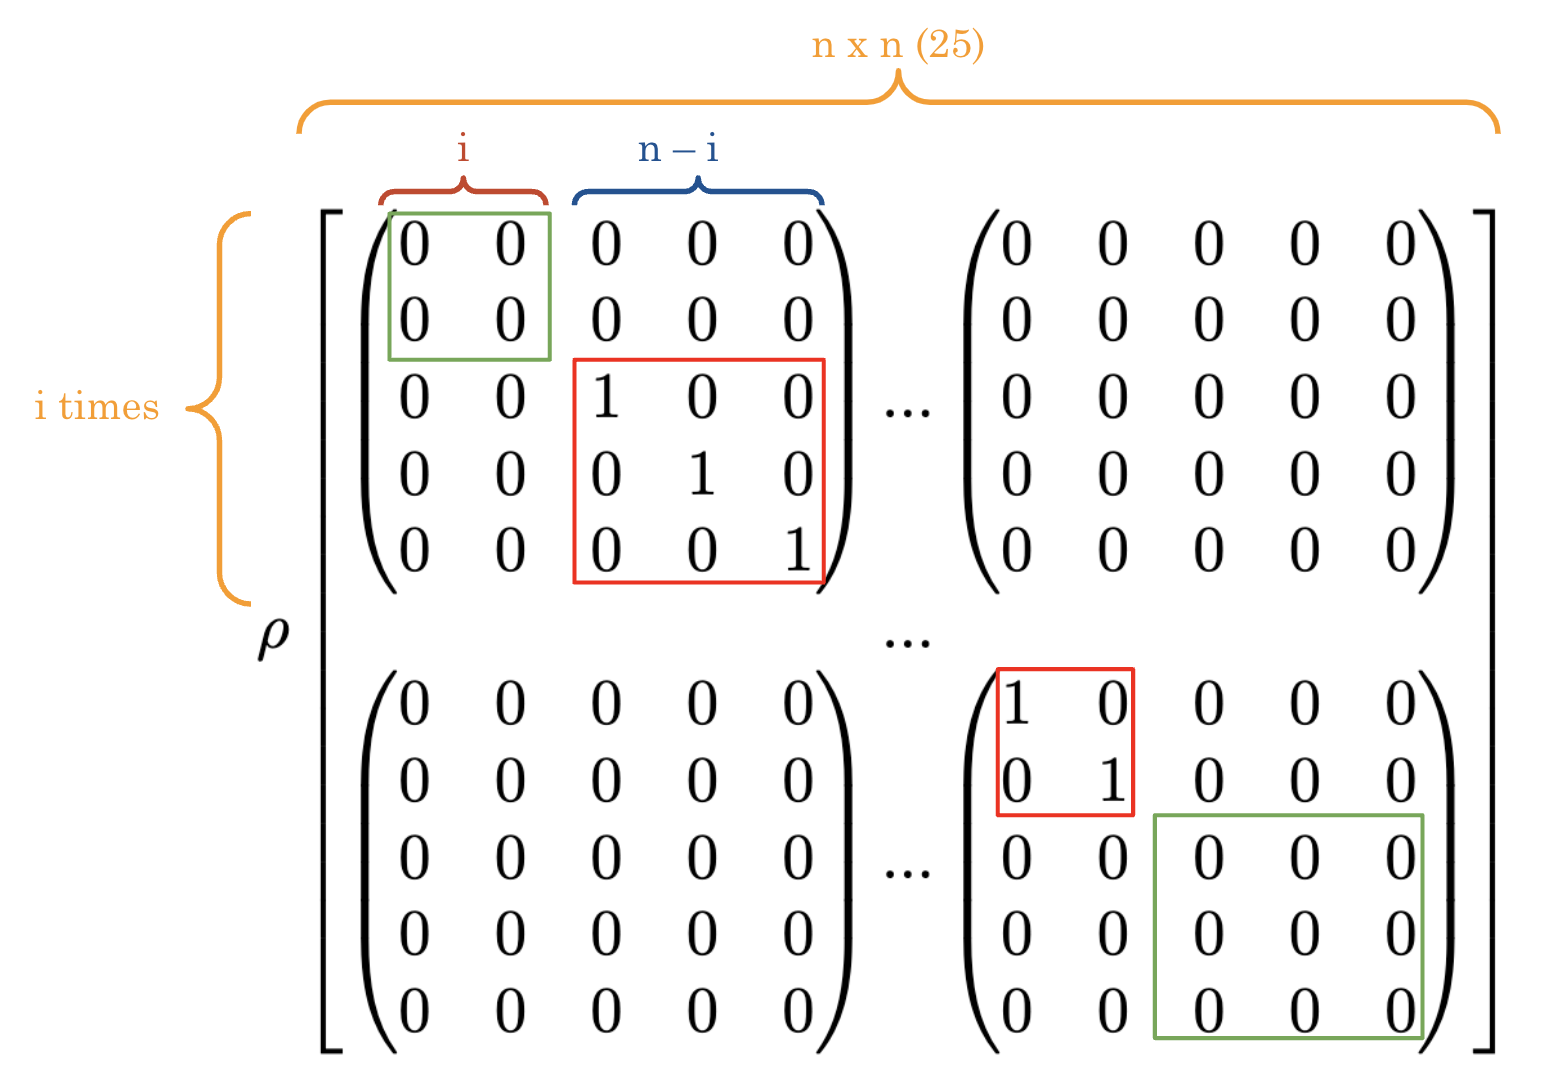
Here, the matrix is zero in all 'allowed' slots. Specifically, the matrix represents five facilities, with two closets and three wards. The upper-left block (encircled by round parentheses) contains zeroes for allowed moves (closet positions exchanged) and ones for disallowed moves (closet and ward locations exchanged). This 'block' repeats along the diagonal of the matrix for the number of closets present– in this case, twice. The remaining diagonal entires have the opposing pattern, as they correspond to locations containing departments (and hence exchanges with storage units are penalized). In our implementation, the penalty value $\rho$ is particularly high, in order to strongly discourage the movement of a hospital ward into a storage closet. This parameter can be readily modified by a customer to best suit the optimization problem at hand.

In [ ]:
# Let's start with new Q1 from before:
Q1_new = Q_1+movement_penalty_new

row_col_penalty = 1000

for i in range(N):
  if i < num_closets:
      for m in range(num_closets, N):
          Q1_new[i * N + m, i * N + m] += row_col_penalty
  else:
      for m in range(self.num_closets):
          Q1_new[i * N + m, i * N + m] += row_col_penalty


# We again optimize:
sampler = SimulatedAnnealingSampler()

# Solve the problem using simulated annealing
response = sampler.sample_qubo(Q1_new, num_reads=1000)

# Print the best solution
locs_1_final = np.array(list(response.first.sample.values())).reshape(N,N)
#print(response.first.sample, "Energy:", response.first.energy)
print(locs_1_final)

## Test Cases


### Trial 1 (Time Dependence)


For our first trial, we consider the distance matrix $$D=\begin{bmatrix}0 & 105 & 100 \\
105 & 0 & 10 \\ 100 & 10 & 0\end{bmatrix}$$ and flow matrices $F_t$ across times $t$ for $t = 0, 1, 2$: $$F_0 = \begin{bmatrix}0 & 5 & 10 \\ 5 & 0 & 100 \\ 10 & 100 & 0\end{bmatrix}, \ F_1 = \begin{bmatrix}0 & 100 & 1 \\ 100 & 0 & 1000 \\ 1 & 1000 & 0\end{bmatrix}, \ F_2 = \begin{bmatrix}0 & 1 & 75 \\ 1 & 0 & 250 \\ 75 & 250 & 0\end{bmatrix}.$$ The corresponding solution matrices $x_t$ across $t = 0, 1, 2$ are $$x_0 = \begin{bmatrix}1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1\end{bmatrix}, \ x_1 = \begin{bmatrix}1 & 0 & 0 \\ 0 & 0 & 1 \\ 0 & 1 & 0\end{bmatrix}, \ x_2 = \begin{bmatrix}1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1\end{bmatrix}.$$ The graph network images across time may be found below.

#### Time $t=0$ picture

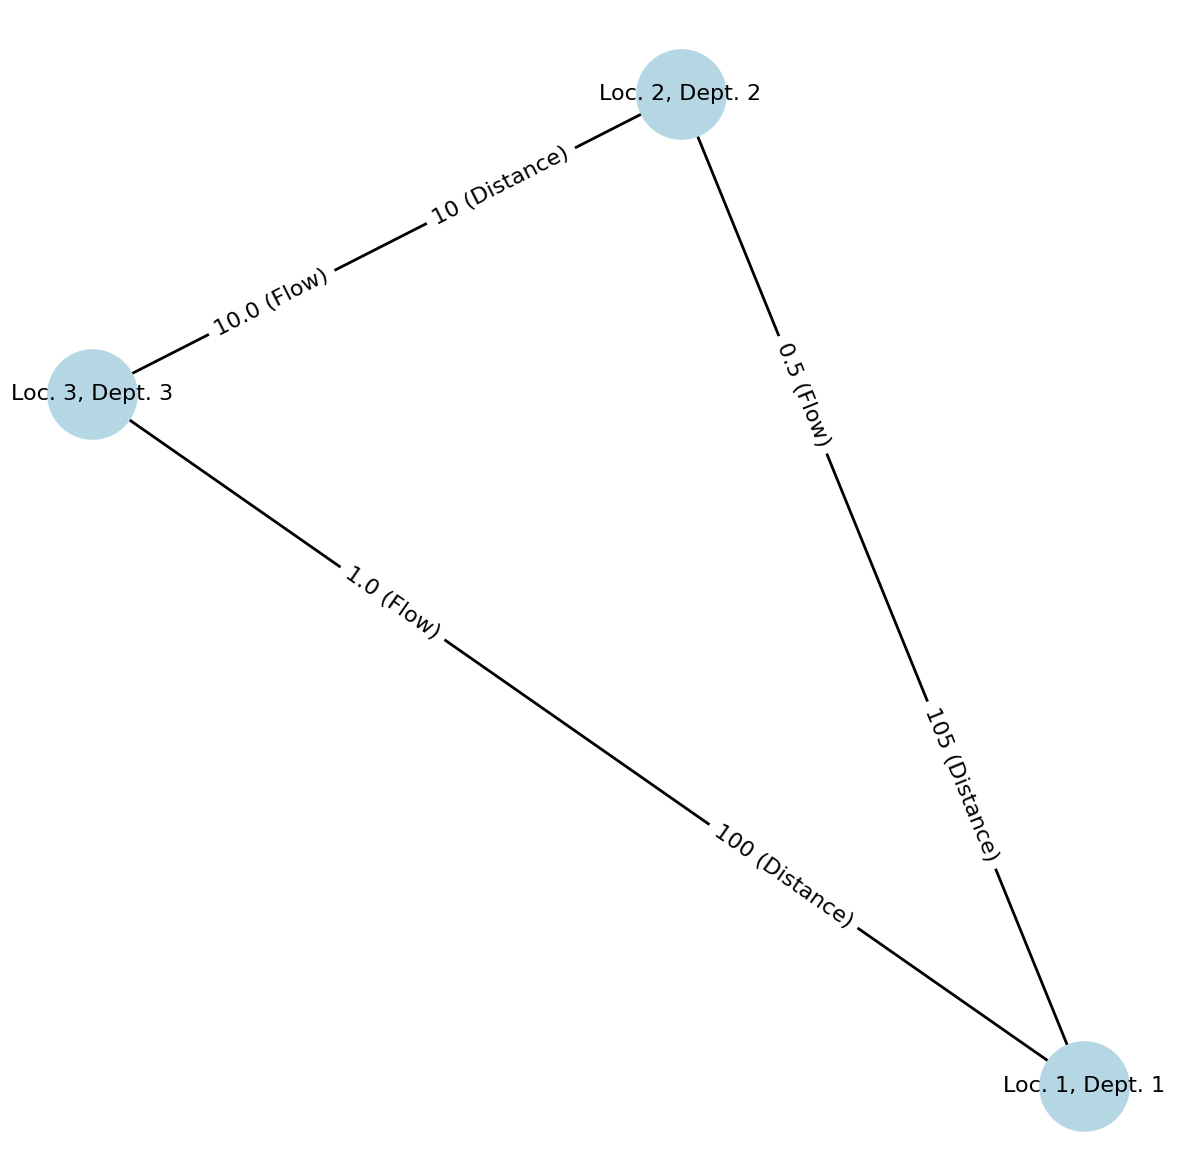

#### Time $t=1$ picture
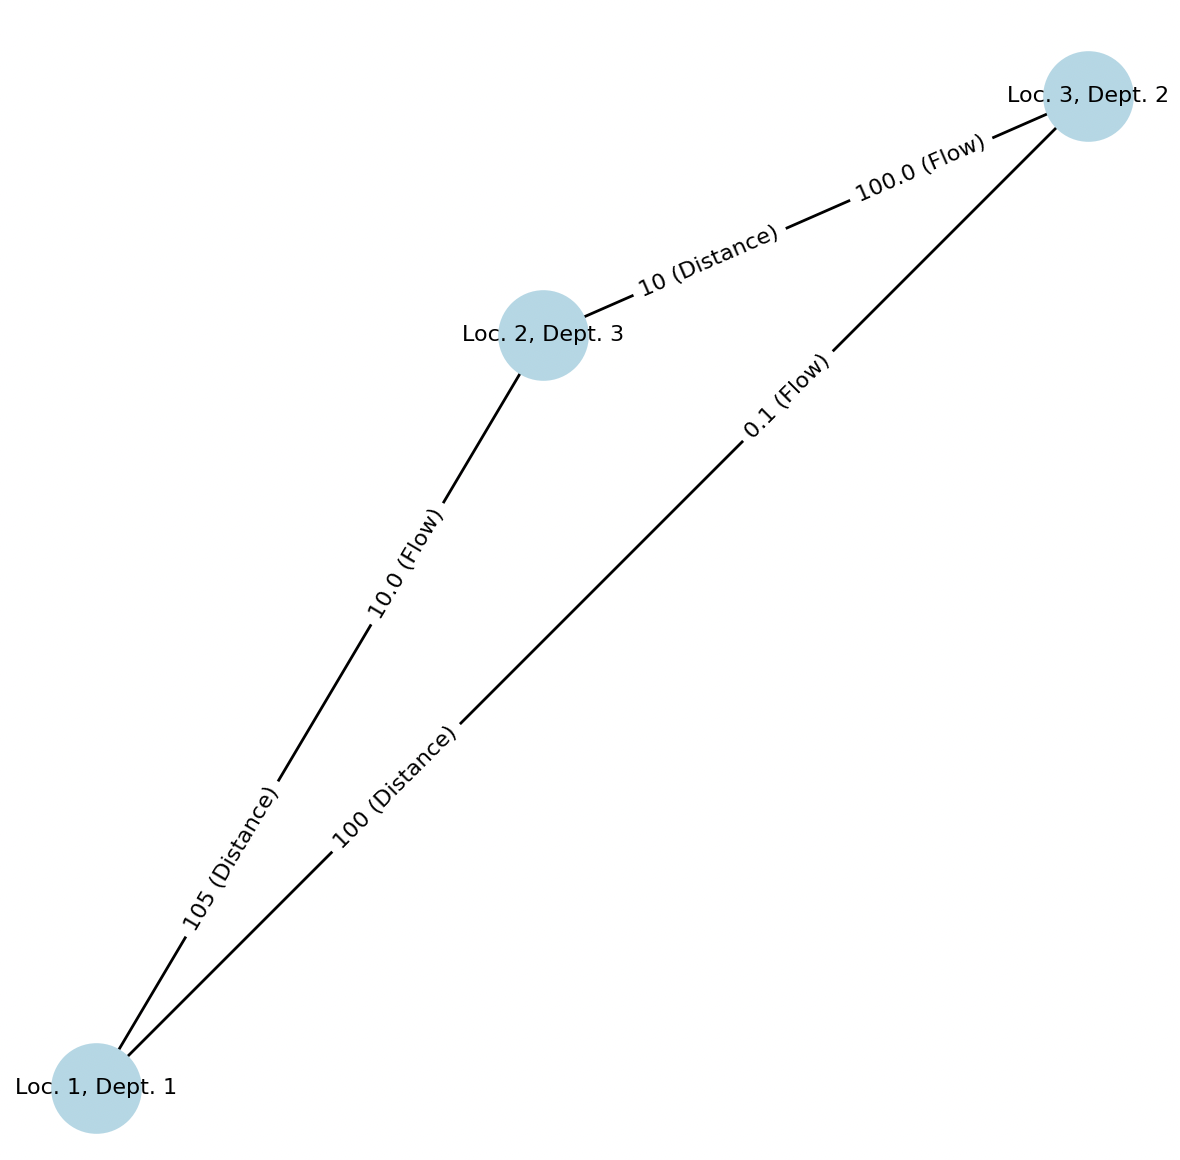

#### Time $t = 2$ picture

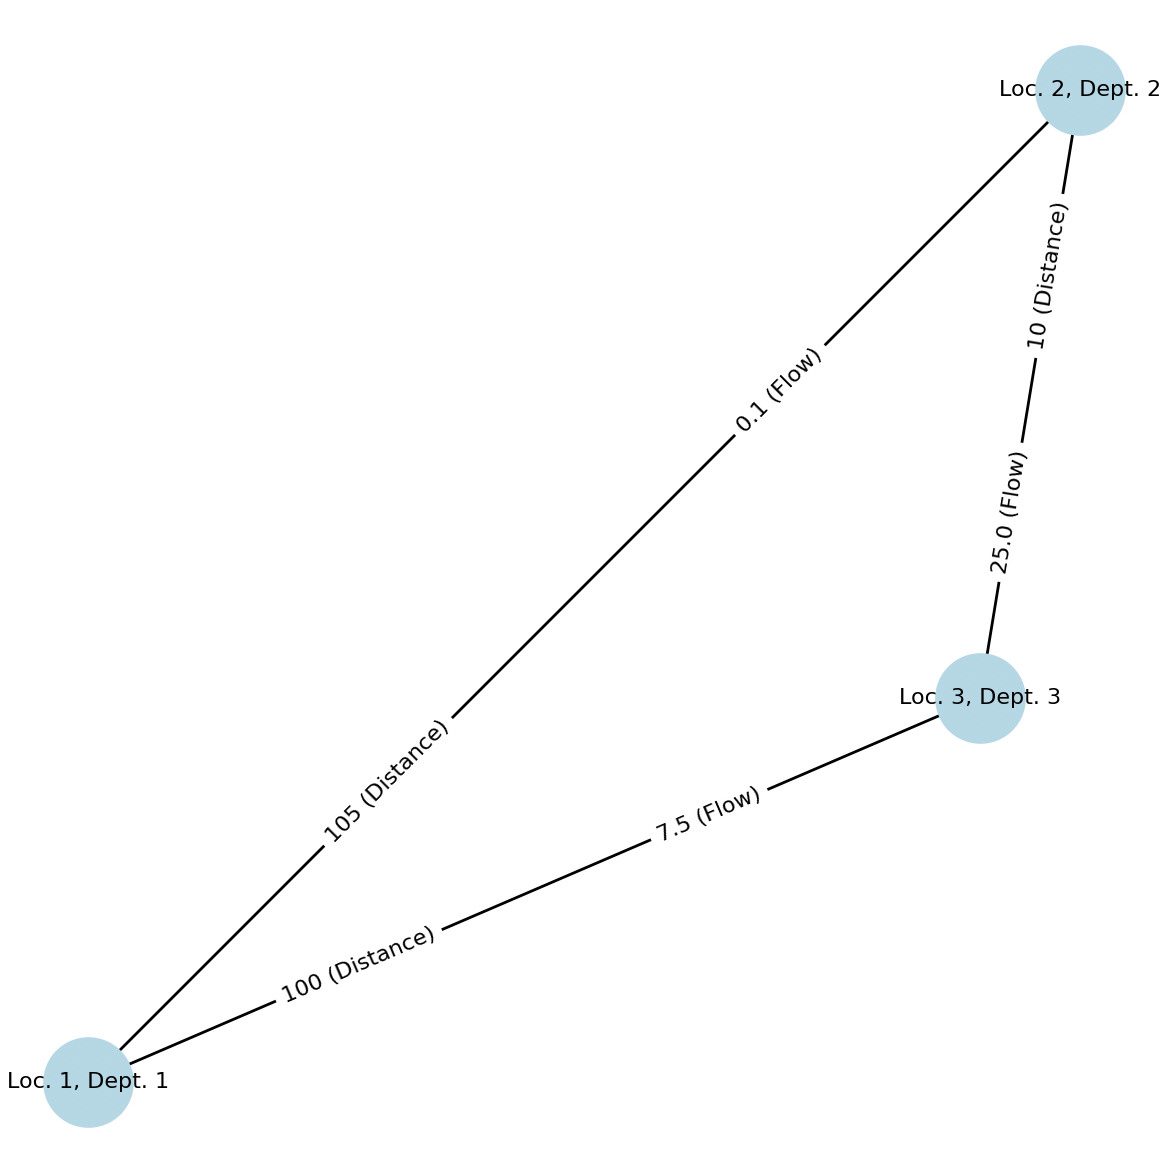


### Trial 2 (Time Dependence)




For our second trial, we consider the distance matrix $$D = \begin{bmatrix}0 & 10 & 30 & 100 \\ 10 & 0 & 5 & 120 \\ 30 & 5 & 0 & 110 \\ 100 & 120 & 110 & 0\end{bmatrix}$$ and flow matrices $F_t$ across times $t$ for $t = 0, 1, 2$: $$F_0 = \begin{bmatrix}0 & 100 & 75 & 5 \\ 100 & 0 & 120 & 2 \\ 75 & 120 & 0 & 3 \\ 5 & 2 & 3 & 0\end{bmatrix}, \ F_1 = \begin{bmatrix}0 & 20 & 150 & 5 \\ 20 & 0 & 50 & 10 \\ 150 & 50 & 0 & 0 \\ 5 & 10 & 0 & 0\end{bmatrix}, \ F_2 = \begin{bmatrix}0 & 100 & 75 & 0 \\ 100 & 0 & 20 & 2 \\ 75 & 20 & 0 & 50 \\ 0 & 2 & 50 & 0\end{bmatrix}.$$ The corresponding solution matrices $x_t$ across $t = 0, 1, 2$ are $$x_0 = \begin{bmatrix}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix}, \ x_1 = \begin{bmatrix}0 & 0 & 1 & 0 \\ 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix}, \ x_2 = \begin{bmatrix}0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix}.$$

### Trial 3 (Closet Distinction)

In this trial, we specifically test the viability of our penalty method in enforcing that "closets" only be able to switch places with one another.

We consider the distance matrix $$D = \begin{bmatrix}0 & 5 & 1 \\ 5 & 0 & 3 \\ 1 & 5 & 0\end{bmatrix}$$ and the flow matrix $$F = \begin{bmatrix}0 & 3 & 2 \\ 3 & 0 & 4 \\ 2 & 4 & 0\end{bmatrix}.$$ The corresponding solution for "closet" indistinguishability is $$x = \begin{bmatrix}0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0\end{bmatrix}$$ and the corresponding solution for "closet" indistinguishability is $$x = \begin{bmatrix}0 & 1 & 0 \\ 1 & 0 & 0 \\ 0 & 0 & 1\end{bmatrix}.$$ By indistinguishability, we refer to "closets" being indistinguishable with and interchangeable with "departments", while distinguishable refers to "closets" being non-interchangeable with "departments. Below are images of the graph networks of the two produced solutions.

#### Indistinguishable Closet Picture

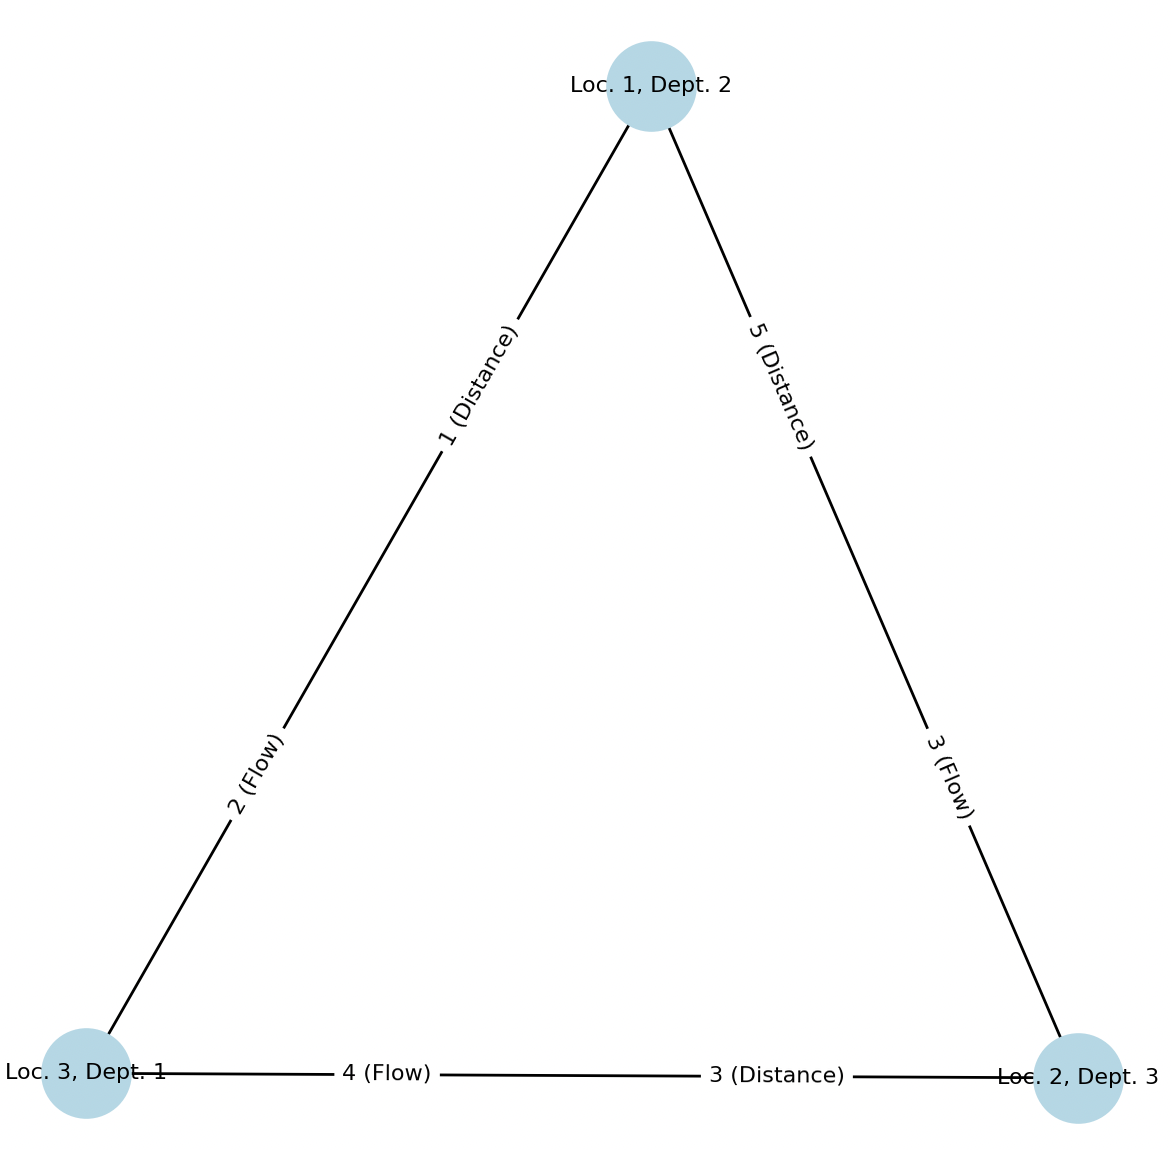

#### Distinguishable Closet Picture

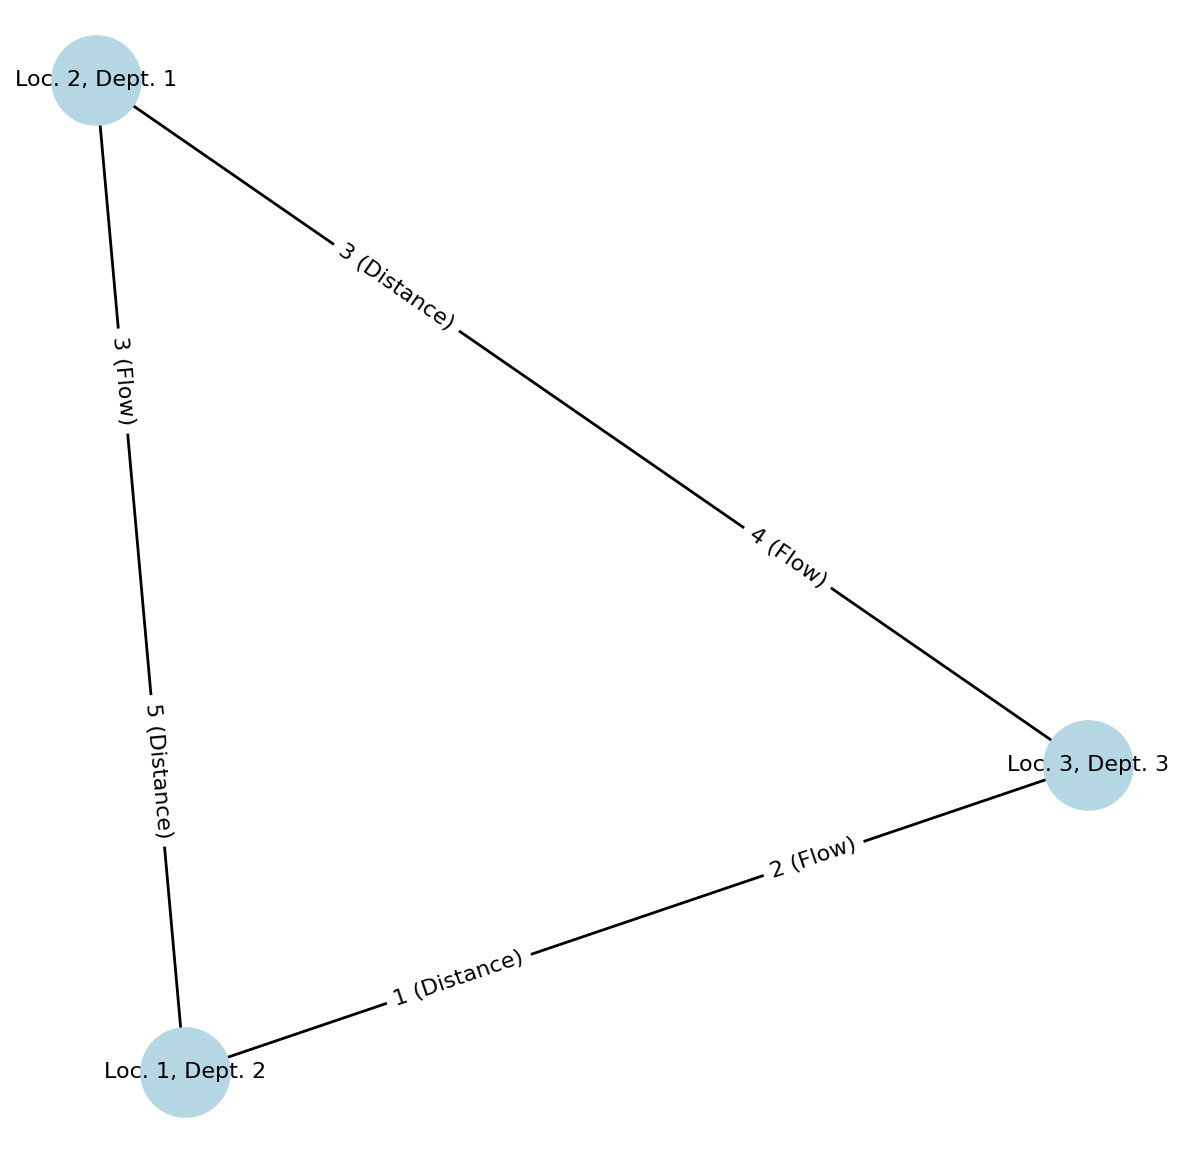

## Applications

Optimization problems are ubiquitous across commercial activities, and their combined utility and computational cost motivate the development of efficient solution methods. Quantum computation, and quantum annealing in particular, have strong potential for efficiently computing nonlinear optimization problems, with further development enabling solutions of higher dimensional problems.

Our library and appraoch to QUBO formulation make optimization problems on current D-Wave circuits accessible to a wide range of consumers. Our formulation of time-evolved cost makes it possible to solve problems of greater complexity and realism, as demonstrated with the classic hospital ward problem with time-varying supply and intake.

Numerous additional applications exist. One promising example is the optimization of commercial fishing routines in response to changing season, Another is the optimziation of airport terminals, and yet another involves portfolio management. In addition, we believe problems in a wide range of disciplines– even those without straightforward QUBO representations– such as crystal structure prodiction and nonlinear dynamical systems can be efficiently solved when reformulated as a time-dependent or nonlinear optimization problem compatible with methods we employed.

In any case, quantum computation has enormous potential for solving optimization problems, and as demonstrated by our work, increasingly realistic schemes could soon be within reach.
